In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import configargparse
from aspire.volume import Volume
from aspire.utils.rotation import Rotation as aspire_Rotation
from scipy.spatial.transform import Rotation as scipy_Rotation
import numpy as np
import os
import logging
import time

from cryomap_align.utils import init_config, try_mkdir, center_vol
from cryomap_align.gauss_opt_utils import run_gaussian_opt
from cryomap_align.opt_refinement import run_nelder_mead_refinement

/home/ds2865/.conda/envs/optimization_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-12-13 17:22:27,829	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


I developed this module in a way that it would be easy for me to use in the future, so some of the functionalities it has are not useful for the project (like reading all my inputs from config files). For this reason I will have to do things in a non-optimal way below. This does not impact the method as it's just unimportant software stuff.

In [3]:
results_refine = np.load("results_with_refinement.npz")
results_noise = np.load("results_for_noise.npz")

['true_mtx',
 'optim_mtx_wemd',
 'refin_mtx_wemd',
 'optim_mtx_l2',
 'refin_mtx_l2',
 'run_time_wemd',
 'run_time_l2']

In [30]:
true_quats = results["true_quats"]
optim_quats_wemd = results["optim_quats_wemd"]
refin_quats_wemd = results["refin_quats_wemd"]
optim_quats_l2 = results["optim_quats_l2"]
refin_quats_l2 = results["refin_quats_l2"]

In [95]:
true_mtx = scipy_Rotation.from_quat(true_quats[0, 0]).as_matrix()
optim_mtx_wemd = scipy_Rotation.from_quat(optim_quats_wemd[0, 0]).as_matrix()
refin_mtx_wemd = scipy_Rotation.from_quat(refin_quats_wemd[0, 0]).as_matrix().transpose((0, 2, 1))
optim_mtx_l2 = scipy_Rotation.from_quat(optim_quats_l2[0, 0]).as_matrix()
refin_mtx_l2 = scipy_Rotation.from_quat(refin_quats_l2[0, 0]).as_matrix().transpose((0, 2, 1))

In [43]:
def calc_error(mtx_stack1, mtx_stack2):

    cos_theta = (np.trace(np.matmul(mtx_stack1, mtx_stack2.transpose((0, 2, 1))), axis1=1, axis2=2) - 1) / 2
    cos_theta[cos_theta > 1] = 1
    cos_theta[cos_theta < -1] = -1
    error = np.arccos(cos_theta) * (180) / np.pi

    return error

In [8]:
list(results_refine.keys())

['true_mtx',
 'optim_max_wemd',
 'refin_max_wemd',
 'optim_max_l2',
 'refin_max_l2',
 'run_time_wemd',
 'run_time_l2']

In [57]:
error_optim_wemd = []
error_optim_l2 = []
error_refin_wemd = []
error_refin_l2 = []

for i in range(results_refine["true_mtx"].shape[1]):

    true_mtx = results_refine["true_mtx"][0, i]
    optim_mtx_wemd = results_refine["optim_max_wemd"][0, i]
    refin_mtx_wemd = results_refine["refin_max_wemd"][0, i]
    optim_mtx_l2 = results_refine["optim_max_l2"][0, i]
    refin_mtx_l2 = results_refine["refin_max_l2"][0, i]

    error_optim_wemd.append(calc_error(true_mtx, optim_mtx_wemd))
    error_refin_wemd.append(calc_error(true_mtx, refin_mtx_wemd))
    error_optim_l2.append(calc_error(true_mtx, optim_mtx_l2))
    error_refin_l2.append(calc_error(true_mtx, refin_mtx_l2))

In [56]:
error_optim_wemd = []
error_optim_l2 = []
error_refin_wemd = []
error_refin_l2 = []

for i in range(results_refine["true_mtx"].shape[1]):

    true_mtx = results_refine["true_mtx"][0, i]
    optim_mtx_wemd = results_refine["optim_max_wemd"][0, i]
    refin_mtx_wemd = results_refine["refin_max_wemd"][0, i]
    optim_mtx_l2 = results_refine["optim_max_l2"][0, i]
    refin_mtx_l2 = results_refine["refin_max_l2"][0, i]

    error_optim_wemd.append(np.linalg.norm(true_mtx - optim_mtx_wemd, axis=(1, 2), ord=2))
    error_refin_wemd.append(np.linalg.norm(true_mtx - refin_mtx_wemd, axis=(1, 2), ord=2))
    error_optim_l2.append(np.linalg.norm(true_mtx -optim_mtx_l2, axis=(1, 2), ord=2))
    error_refin_l2.append(np.linalg.norm(true_mtx -refin_mtx_l2, axis=(1, 2), ord=2))

Text(0.5, 1.0, 'L2 Loss')

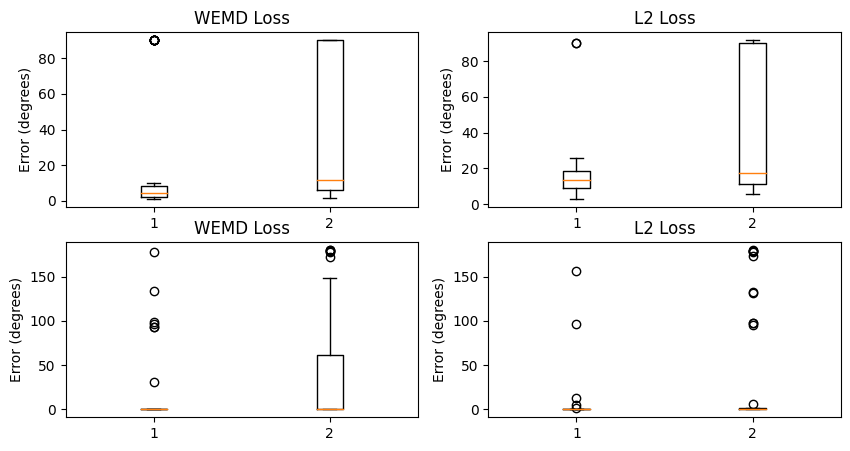

In [58]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(10, 5))

ax[0, 0].boxplot(error_optim_wemd)
#ax[0].set_xticklabels(["P1", "P2"])
ax[0, 0].set_ylabel("Error (degrees)")
ax[0, 0].set_title("WEMD Loss")

ax[0, 1].boxplot(error_optim_l2)
#ax[1].set_xticklabels(["P1", "P2"])
ax[0, 1].set_ylabel("Error (degrees)")
ax[0, 1].set_title("L2 Loss")

ax[1, 0].boxplot(error_refin_wemd)
#ax[0].set_xticklabels(["P1", "P2"])    
ax[1, 0].set_ylabel("Error (degrees)")
ax[1, 0].set_title("WEMD Loss")
ax[1, 1].boxplot(error_refin_l2)

#ax[1].set_xticklabels(["P1", "P2"])
ax[1, 1].set_ylabel("Error (degrees)")
ax[1, 1].set_title("L2 Loss")

# ax[0, 0].set_ylim([0.0, 5.0])
# ax[0, 1].set_ylim([0.0, 5.0])
# ax[1, 0].set_ylim([0.0, 5.0])
# ax[1, 1].set_ylim([0.0, 5.0])

In [60]:
np.argmax(error_optim_wemd[0])

43

In [61]:
true_mtx = results_refine["true_mtx"][0, 0, 43]
optim_mtx = results_refine["optim_max_wemd"][0, 0, 43]
refin_mtx = results_refine["refin_max_wemd"][0, 0, 43]


In [62]:
true_mtx, optim_mtx

(array([[ 0.3455638 , -0.73860651, -0.57883167],
        [-0.90520263, -0.09976554, -0.41310418],
        [ 0.24737397,  0.66671377, -0.70306391]]),
 array([[ 0.33441222, -0.69691247, -0.63441426],
        [-0.90000379, -0.03646333, -0.43435419],
        [-0.27957401, -0.7162286 ,  0.63941765]]))

In [64]:
vol0 = Volume.load("volumes/emd_3683.map.gz")

2023-12-13 17:45:34,918 INFO [aspire.volume.volume] volumes/emd_3683.map.gz with dtype float32 loaded as None


In [66]:
# rotate volume with true and refined
rot_true = aspire_Rotation.from_matrix(true_mtx.astype(np.float32))
rot_refin = aspire_Rotation.from_matrix(refin_mtx.astype(np.float32))
rot_optim = aspire_Rotation.from_matrix(optim_mtx.astype(np.float32))

vol0_rot_true = vol0.rotate(rot_true)
vol0_rot_refin = vol0.rotate(rot_refin)
vol0_rot_optim = vol0.rotate(rot_optim)

# save volumes
vol0_rot_true.save("emd_3683_true.map.gz")
vol0_rot_refin.save("emd_3683_refin.map.gz")
vol0_rot_optim.save("emd_3683_optim.map.gz")